In [1]:
%matplotlib inline

import os
from allennlp.nn.util import move_to_device
import torch
import numpy as np

import pandas as pd
from umap import UMAP

import matplotlib.pyplot as plt
import seaborn as sns

import json

from SocialMediaIE.data.tokenization import get_match_iter, get_match_object

from SocialMediaIE.predictor.model_predictor_classification import run, get_args, PREFIX, get_model_output, output_to_json


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
sns.set_context("talk")
sns.set_style("ticks")

In [3]:
MODEL_NAME="all_multitask_shared_bilstm_l2_0_lr_1e-3"
SERIALIZATION_DIR = os.path.realpath(f"../data/models_classification/{MODEL_NAME}/")
args = get_args(PREFIX, SERIALIZATION_DIR)
TASKS, vocab, model, readers, test_iterator = run(args)

F:\ProgramData\Miniconda3\envs\SocialMediaIE\lib\site-packages\torch\nn\modules\rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [4]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    if "elmo" not in param_tensor:
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
word_embeddings.token_embedder_tokens._projection.weight 	 torch.Size([100, 1024])
word_embeddings.token_embedder_tokens._projection.bias 	 torch.Size([100])
encoders.abusive._module.moduleList.0.weight_ih_l0 	 torch.Size([400, 100])
encoders.abusive._module.moduleList.0.weight_hh_l0 	 torch.Size([400, 100])
encoders.abusive._module.moduleList.0.bias_ih_l0 	 torch.Size([400])
encoders.abusive._module.moduleList.0.bias_hh_l0 	 torch.Size([400])
encoders.abusive._module.moduleList.0.weight_ih_l0_reverse 	 torch.Size([400, 100])
encoders.abusive._module.moduleList.0.weight_hh_l0_reverse 	 torch.Size([400, 100])
encoders.abusive._module.moduleList.0.bias_ih_l0_reverse 	 torch.Size([400])
encoders.abusive._module.moduleList.0.bias_hh_l0_reverse 	 torch.Size([400])
encoders.sentiment._module.moduleList.0.weight_ih_l0 	 torch.Size([400, 100])
encoders.sentiment._module.moduleList.0.weight_hh_l0 	 torch.Size([400, 100])
encoders.sentiment._module.moduleList.0.bias_ih_l0 	 t

classifier.semeval_sentiment._classification_layer.bias 	 torch.Size([3])
classifier.clarin_sentiment._text_field_embedder.token_embedder_tokens._projection.weight 	 torch.Size([100, 1024])
classifier.clarin_sentiment._text_field_embedder.token_embedder_tokens._projection.bias 	 torch.Size([100])
classifier.clarin_sentiment._seq2vec_encoder._module.moduleList.0.weight_ih_l0 	 torch.Size([400, 100])
classifier.clarin_sentiment._seq2vec_encoder._module.moduleList.0.weight_hh_l0 	 torch.Size([400, 100])
classifier.clarin_sentiment._seq2vec_encoder._module.moduleList.0.bias_ih_l0 	 torch.Size([400])
classifier.clarin_sentiment._seq2vec_encoder._module.moduleList.0.bias_hh_l0 	 torch.Size([400])
classifier.clarin_sentiment._seq2vec_encoder._module.moduleList.0.weight_ih_l0_reverse 	 torch.Size([400, 100])
classifier.clarin_sentiment._seq2vec_encoder._module.moduleList.0.weight_hh_l0_reverse 	 torch.Size([400, 100])
classifier.clarin_sentiment._seq2vec_encoder._module.moduleList.0.bias_ih_l0

In [5]:
k1 = "encoders.abusive._module.moduleList.0.weight_ih_l0"
k2 = "encoders.sentiment._module.moduleList.0.weight_ih_l0"
model.state_dict()[k1] == model.state_dict()[k2]

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0', dtype=torch.uint8)

In [6]:
print("Model's state_dict:")

all_weights = []
all_keys = []
all_tasks = []

for param_tensor in model.state_dict():
    if param_tensor.endswith("._classification_layer.weight"):
        task_name = param_tensor.split(".")[1]
        all_tasks.append(task_name)
        vocab_items = [vocab.get_token_from_index(i, task_name) for i in range(vocab.get_vocab_size(task_name))]
        task_classifier_weights = model.state_dict()[param_tensor]
        all_weights.append(task_classifier_weights.cpu().numpy())
        all_keys.extend([f"{task_name}.{v}" for v in vocab_items])
        print(f"{task_name}\t{vocab_items}\t{task_classifier_weights.size()}")
all_weights = np.vstack(all_weights)
all_weights.shape, all_keys

Model's state_dict:
founta_abusive	['normal', 'spam', 'abusive', 'hateful']	torch.Size([4, 200])
waseem_abusive	['none', 'sexism', 'racism']	torch.Size([3, 200])
sarcasm_uncertainity	['not_sarcasm', 'sarcasm']	torch.Size([2, 200])
veridicality_uncertainity	['uncertain', 'definitely_yes', 'probably_yes', 'probably_no', 'definitely_no']	torch.Size([5, 200])
semeval_sentiment	['positive', 'neutral', 'negative']	torch.Size([3, 200])
clarin_sentiment	['neutral', 'positive', 'negative']	torch.Size([3, 200])
politics_sentiment	['negative', 'neutral', 'positive']	torch.Size([3, 200])
other_sentiment	['negative', 'neutral', 'positive']	torch.Size([3, 200])


((26, 200),
 ['founta_abusive.normal',
  'founta_abusive.spam',
  'founta_abusive.abusive',
  'founta_abusive.hateful',
  'waseem_abusive.none',
  'waseem_abusive.sexism',
  'waseem_abusive.racism',
  'sarcasm_uncertainity.not_sarcasm',
  'sarcasm_uncertainity.sarcasm',
  'veridicality_uncertainity.uncertain',
  'veridicality_uncertainity.definitely_yes',
  'veridicality_uncertainity.probably_yes',
  'veridicality_uncertainity.probably_no',
  'veridicality_uncertainity.definitely_no',
  'semeval_sentiment.positive',
  'semeval_sentiment.neutral',
  'semeval_sentiment.negative',
  'clarin_sentiment.neutral',
  'clarin_sentiment.positive',
  'clarin_sentiment.negative',
  'politics_sentiment.negative',
  'politics_sentiment.neutral',
  'politics_sentiment.positive',
  'other_sentiment.negative',
  'other_sentiment.neutral',
  'other_sentiment.positive'])

In [7]:
X_embedded = UMAP(n_components=2).fit_transform(all_weights)

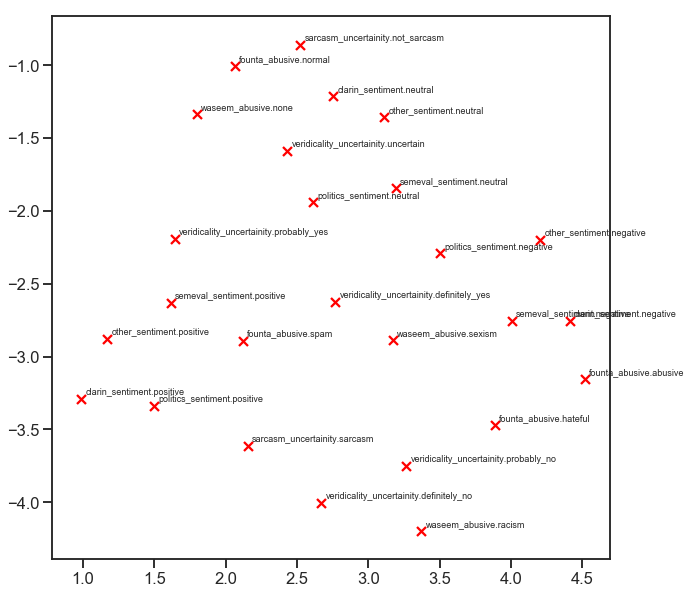

In [8]:
fig = plt.figure(figsize=(10, 10))

for i, (key, (x, y)) in enumerate(zip(all_keys, X_embedded)):
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+.03, y+.03, key, fontsize=9)
plt.show()

In [9]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [10]:
df = pd.DataFrame({"task_labels": all_keys, "d1": X_embedded[:, 0], "d2": X_embedded[:, 1]})
df = pd.concat([df, df.task_labels.str.split(".", expand=True).rename(columns={0: "task", 1: "label"})], axis=1)
df.head()

,task_labels,d1,d2,task,label
0,founta_abusive.normal,2.063343,-1.007219,founta_abusive,normal
1,founta_abusive.spam,2.119366,-2.892117,founta_abusive,spam
2,founta_abusive.abusive,4.516266,-3.152872,founta_abusive,abusive
3,founta_abusive.hateful,3.886361,-3.466821,founta_abusive,hateful
4,waseem_abusive.none,1.797528,-1.338207,waseem_abusive,none


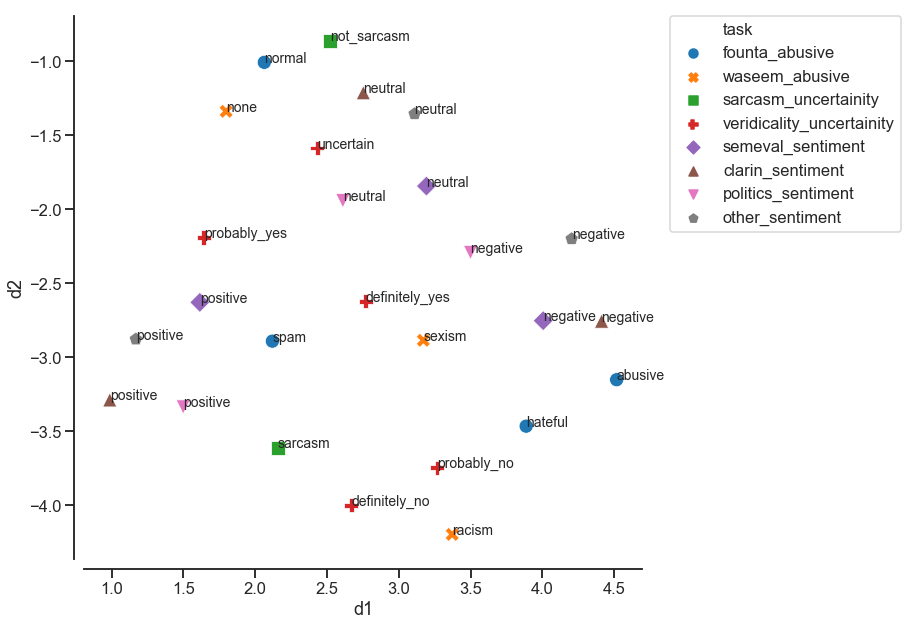

In [11]:
fig = plt.figure(figsize=(10, 10))

ax = sns.scatterplot(x="d1", y="d2", data=df, style="task", hue="task", s=200)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, row in df.iterrows():
    #ax.text(row.d1+.1, row.d2+.1, row.label, fontsize=16)
    ax.annotate(
        row.label, 
        xy=(row.d1, row.d2), xytext=(0, 0), 
        textcoords='offset points',
        fontsize=14
    )
    
sns.despine(offset=10)
plt.savefig(f"../figures/multitask_learning/classification_{MODEL_NAME}_labels.pdf", bbox_inches="tight")